# Comparing Two Groups: Parametric Tests
Parametric Test	: Distribution	Assumes data follows a specific distribution (usually normal distributiosn).
Non-Parametric Test: 	Does not assume any specific distribution (distribution-free)

Assume data follows a specific distribution (usually normal distribution)

Hypothesis testing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.power import TTestIndPower, TTestPower
import warnings
from scipy.stats import chi2_contingency

In [2]:
# Suppress warnings
warnings.filterwarnings('ignore')

# Set visualization style consistent with previous tutorials
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [3]:
# Load the UCI Heart Disease dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
column_names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
                'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']
heart_data = pd.read_csv(url, names=column_names, na_values='?')

# Display the first few rows of the dataset
print("First 5 rows of the UCI Heart Disease dataset:")
print(heart_data.head())

First 5 rows of the UCI Heart Disease dataset:
    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1  67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2  67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3  37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4  41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   

   slope   ca  thal  target  
0    3.0  0.0   6.0       0  
1    2.0  3.0   3.0       2  
2    2.0  2.0   7.0       1  
3    3.0  0.0   3.0       0  
4    1.0  0.0   3.0       0  


In [4]:
# Basic dataset information
print("\nDataset Information:")
heart_data.info()


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  target    303 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 33.3 KB


In [5]:
# Check for missing values
print("\nMissing values per column:")
print(heart_data.isnull().sum())


Missing values per column:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
target      0
dtype: int64


In [6]:
# Replace missing values with the median for numerical columns
heart_data = heart_data.fillna(heart_data.median())

In [7]:
# Convert target variable to binary (0 = no disease, 1 = disease)
heart_data['target'] = heart_data['target'].apply(lambda x: 0 if x == 0 else 1)

# Convert sex to categorical for better interpretability (0 = female, 1 = male)
heart_data['sex'] = heart_data['sex'].map({0: 'Female', 1: 'Male'})

# Basic statistics
print("\nBasic Statistical Summary:")
print(heart_data.describe())


Basic Statistical Summary:
              age          cp    trestbps        chol         fbs     restecg  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean    54.438944    3.158416  131.689769  246.693069    0.148515    0.990099   
std      9.038662    0.960126   17.599748   51.776918    0.356198    0.994971   
min     29.000000    1.000000   94.000000  126.000000    0.000000    0.000000   
25%     48.000000    3.000000  120.000000  211.000000    0.000000    0.000000   
50%     56.000000    3.000000  130.000000  241.000000    0.000000    1.000000   
75%     61.000000    4.000000  140.000000  275.000000    0.000000    2.000000   
max     77.000000    4.000000  200.000000  564.000000    1.000000    2.000000   

          thalach       exang     oldpeak       slope          ca        thal  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean   149.607261    0.326733    1.039604    1.600660    0.663366    4.722772   

# 1. Hypothesis Testing

1. Null Hypothesis (H₀):
   - Assumes no effect, no difference, or no relationship
   - The 'status quo' or default position
   - What we assume is true until evidence suggests otherwise

2. Alternative Hypothesis (H₁):
   - Proposes an effect, difference, or relationship exists
   - What we're typically trying to demonstrate
   - May be one-tailed (directional) or two-tailed (non-directional)

3. Test Statistic:
   - Quantifies how different the observed data is from what we'd expect under H₀
   - Examples: t-statistic, F-statistic, chi-square

4. P-value:
   - Probability of observing a result at least as extreme as the one obtained,
     if the null hypothesis were true
   - Small p-value (≤ α) → reject H₀
   - Large p-value (> α) → fail to reject H₀
   - Typical significance level (α) = 0.05

5. Decision Rules:
   - If p ≤ α, reject H₀ (statistically significant result)
   - If p > α, fail to reject H₀ (not statistically significant)

6. Common Misinterpretations of P-values:
   - P-value is NOT the probability that H₀ is true
   - P-value is NOT the probability that the finding is due to chance
   - P-value does NOT indicate the size or importance of an effect
   - Statistical significance does NOT imply practical significance

7. Types of Errors:
   - Type I Error (False Positive): Rejecting H₀ when it's actually true
     Probability = α (significance level)
   - Type II Error (False Negative): Failing to reject H₀ when it's actually false
     Probability = β
   - Power = 1 - β (Probability of correctly rejecting a false H₀)

# 2. P-value Visualization with Actual Data

Plot disease and no disease distributions and visualize t-test from our data against theoretical t-distribution. Note that the theoretical distribution only depends on the degrees of freedom (n1+n2-2), in our case 301 (303-2) degrees. <p>
We use scipy.stats.ttest_ind for our t-test.

Example with Age: Comparing age between patients with and without heart disease


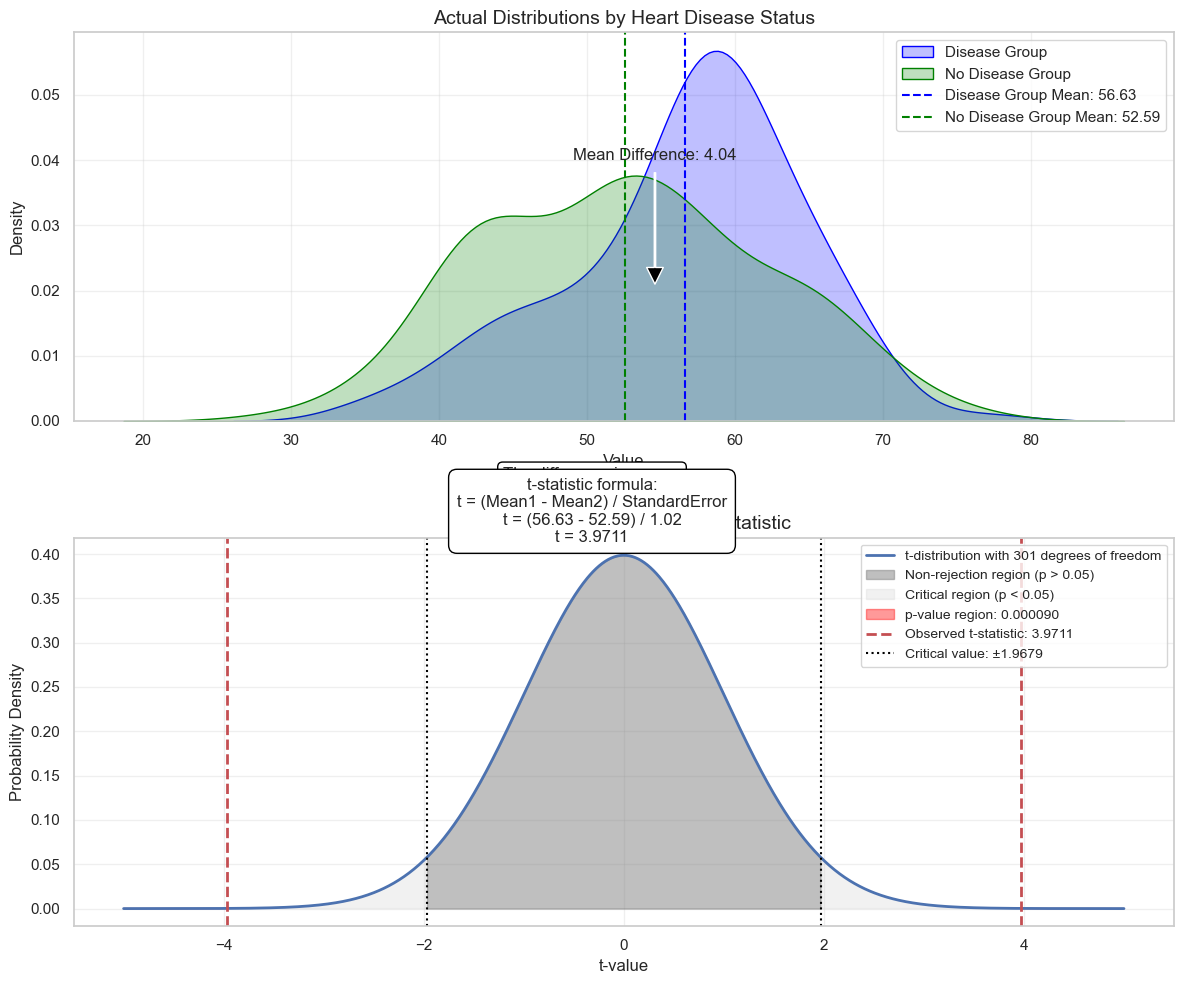


Explanation of the t-test and visualizations:
1. Top plot: Shows the actual distribution of values in both groups
   - Group 1 mean: 56.63
   - Group 2 mean: 52.59
   - Mean difference: 4.04

2. Bottom plot: Shows the theoretical t-distribution with 301 degrees of freedom
   - The t-statistic of 3.9711 is calculated by standardizing the mean difference
   - The formula divides the mean difference by the standard error (1.02)
   - The p-value of 0.000090 is the probability of observing a t-statistic of
     3.9711 or more extreme if there were no real difference between groups
   - Since p-value (0.000090) < 0.05, we reject the null hypothesis
   - Conclusion: There is a statistically significant difference between groups

3. Key concept: The t-distribution shape depends only on the degrees of freedom (301),
   not on the specific values in our dataset

Example with Cholesterol: Comparing cholesterol between patients with and without heart disease


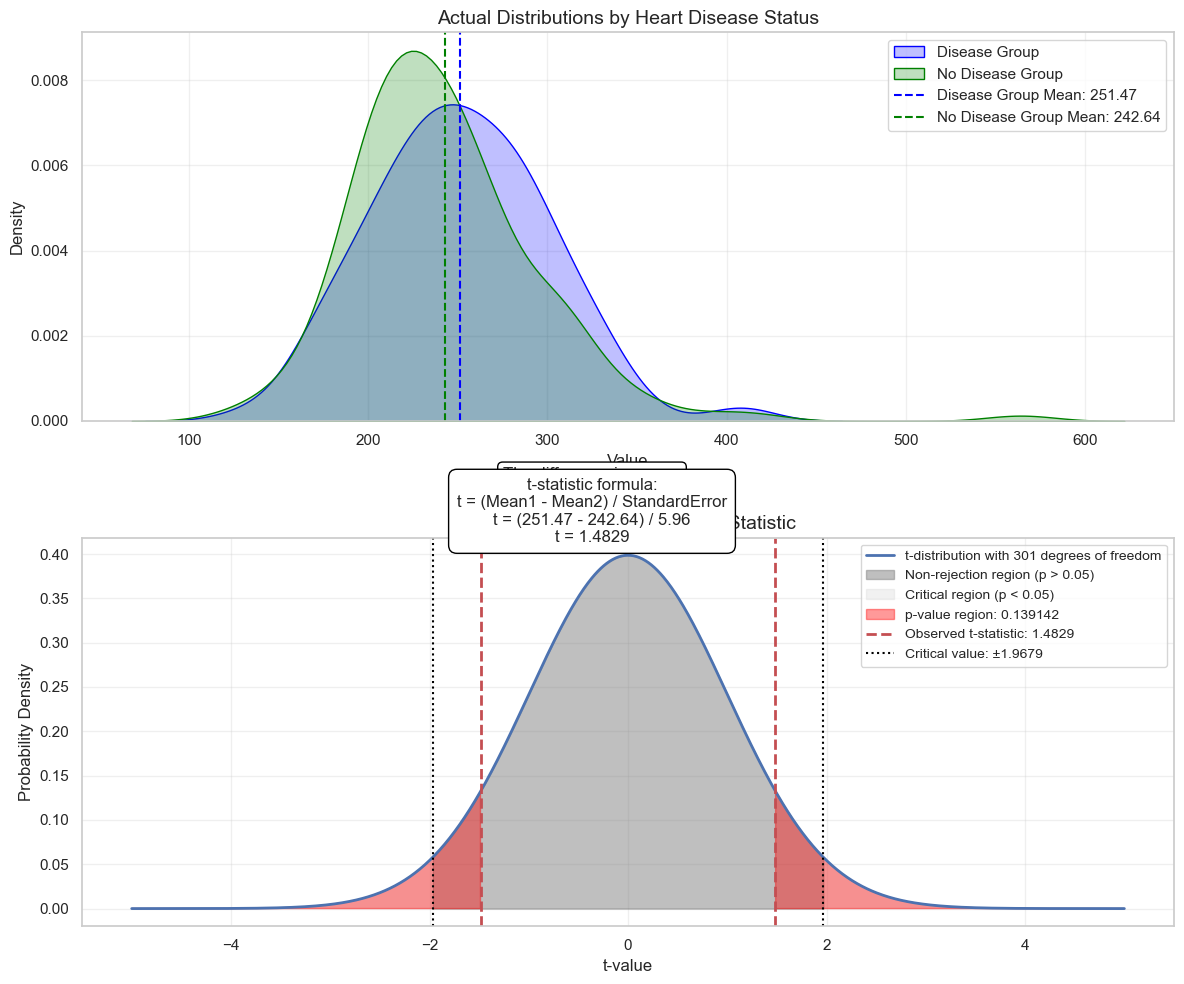


Explanation of the t-test and visualizations:
1. Top plot: Shows the actual distribution of values in both groups
   - Group 1 mean: 251.47
   - Group 2 mean: 242.64
   - Mean difference: 8.83

2. Bottom plot: Shows the theoretical t-distribution with 301 degrees of freedom
   - The t-statistic of 1.4829 is calculated by standardizing the mean difference
   - The formula divides the mean difference by the standard error (5.96)
   - The p-value of 0.139142 is the probability of observing a t-statistic of
     1.4829 or more extreme if there were no real difference between groups
   - Since p-value (0.139142) > 0.05, we fail to reject the null hypothesis
   - Conclusion: There is not enough evidence to claim a significant difference

3. Key concept: The t-distribution shape depends only on the degrees of freedom (301),
   not on the specific values in our dataset


(np.float64(1.4829209163941466), np.float64(0.13914167020436527), 301)

In [8]:
def visualize_t_test_with_actual_data(group1, group2, alpha=0.05):
    """
    Visualize t-test with both actual data distributions and theoretical t-distribution
    using the actual heart disease dataset.

    Parameters:
    -----------
    group1 : array (or series) of First group's data (e.g., disease group)
    group2 : array (or series) of Second group's data (e.g., no disease group)
    """
    # Create a figure with 2 subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Plot 1: Actual distributions
    sns.kdeplot(group1, ax=ax1, fill=True, color='blue', label='Disease Group')
    sns.kdeplot(group2, ax=ax1, fill=True, color='green', label='No Disease Group')

    # Add vertical lines for means
    mean1, mean2 = group1.mean(), group2.mean()
    ax1.axvline(mean1, color='blue', linestyle='--',
               label=f'Disease Group Mean: {mean1:.2f}')
    ax1.axvline(mean2, color='green', linestyle='--',
               label=f'No Disease Group Mean: {mean2:.2f}')

    # Add annotation for mean difference
    mean_diff = mean1 - mean2
    ax1.annotate(f'Mean Difference: {mean_diff:.2f}',
                xy=((mean1 + mean2) / 2, 0.02),
                xytext=((mean1 + mean2) / 2, 0.04),
                ha='center',
                arrowprops=dict(facecolor='black', shrink=0.05, width=1))

    ax1.set_title(f'Actual Distributions by Heart Disease Status', fontsize=14)
    ax1.set_xlabel('Value', fontsize=12)
    ax1.set_ylabel('Density', fontsize=12)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Calculate t-statistic and p-value
    t_stat, p_val = stats.ttest_ind(group1, group2)

    # Calculate degrees of freedom
    n1, n2 = len(group1), len(group2)
    df = n1 + n2 - 2

    # Plot 2: Theoretical t-distribution
    x = np.linspace(-5, 5, 1000)
    y = stats.t.pdf(x, df)

    # Plot the t-distribution
    ax2.plot(x, y, 'b-', lw=2, label=f't-distribution with {df} degrees of freedom')

    # Fill the central region (non-rejection region)
    t_crit = stats.t.ppf(1-alpha/2, df)
    ax2.fill_between(x, y, where=(x >= -t_crit) & (x <= t_crit),
                    color='gray', alpha=0.5,
                    label=f'Non-rejection region (p > {alpha})')

    # Fill the rejection regions
    ax2.fill_between(x, y, where=(x <= -t_crit) | (x >= t_crit),
                    color='lightgray', alpha=0.3,
                    label=f'Critical region (p < {alpha})')

    # Fill the observed p-value region
    ax2.fill_between(x, y, where=(x <= -abs(t_stat)) | (x >= abs(t_stat)),
                    color='red', alpha=0.4,
                    label=f'p-value region: {p_val:.6f}')

    # Add vertical lines for observed t-statistic
    ax2.axvline(t_stat, color='r', linestyle='--', lw=2,
                label=f'Observed t-statistic: {t_stat:.4f}')
    ax2.axvline(-t_stat, color='r', linestyle='--', lw=2)

    # Add critical value lines
    ax2.axvline(t_crit, color='black', linestyle=':', lw=1.5,
                label=f'Critical value: ±{t_crit:.4f}')
    ax2.axvline(-t_crit, color='black', linestyle=':', lw=1.5)

    # Add labels and legend
    ax2.set_title("T-Distribution with Observed T-Statistic", fontsize=14)
    ax2.set_xlabel('t-value', fontsize=12)
    ax2.set_ylabel('Probability Density', fontsize=12)
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc='best', fontsize=10)

    # Connection between plots - show how the difference leads to the t-statistic
    arrow_props = dict(facecolor='black', width=1.5, headwidth=8)
    fig.text(0.5, 0.5, "The difference in means\nis standardized to get\nthe t-statistic",
             ha='center', va='center', fontsize=12,
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1))

    # Add formula for t-statistic in a simpler format
    std1, std2 = group1.std(), group2.std()
    pooled_std = np.sqrt(((n1-1)*std1**2 + (n2-1)*std2**2) / (n1+n2-2))
    std_error = pooled_std * np.sqrt(1/n1 + 1/n2)

    # Add the formula as regular text instead of LaTeX
    formula_text = (f"t-statistic formula:\n"
                   f"t = (Mean1 - Mean2) / StandardError\n"
                   f"t = ({mean1:.2f} - {mean2:.2f}) / {std_error:.2f}\n"
                   f"t = {t_stat:.4f}")

    fig.text(0.5, 0.45, formula_text, ha='center', fontsize=12,
             bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="black", lw=1))

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.3)
    plt.show()

    # Detailed explanation
    print("\nExplanation of the t-test and visualizations:")
    print(f"1. Top plot: Shows the actual distribution of values in both groups")
    print(f"   - Group 1 mean: {mean1:.2f}")
    print(f"   - Group 2 mean: {mean2:.2f}")
    print(f"   - Mean difference: {mean_diff:.2f}")

    print(f"\n2. Bottom plot: Shows the theoretical t-distribution with {df} degrees of freedom")
    print(f"   - The t-statistic of {t_stat:.4f} is calculated by standardizing the mean difference")
    print(f"   - The formula divides the mean difference by the standard error ({std_error:.2f})")
    print(f"   - The p-value of {p_val:.6f} is the probability of observing a t-statistic of")
    print(f"     {abs(t_stat):.4f} or more extreme if there were no real difference between groups")

    if p_val < alpha:
        print(f"   - Since p-value ({p_val:.6f}) < {alpha}, we reject the null hypothesis")
        print(f"   - Conclusion: There is a statistically significant difference between groups")
    else:
        print(f"   - Since p-value ({p_val:.6f}) > {alpha}, we fail to reject the null hypothesis")
        print(f"   - Conclusion: There is not enough evidence to claim a significant difference")

    print(f"\n3. Key concept: The t-distribution shape depends only on the degrees of freedom ({df}),")
    print(f"   not on the specific values in our dataset")

    return t_stat, p_val, df

# Use the t-test visualization with actual age data by heart disease status
print("Example with Age: Comparing age between patients with and without heart disease")
disease_group = heart_data[heart_data['target'] == 1]['age']
no_disease_group = heart_data[heart_data['target'] == 0]['age']
visualize_t_test_with_actual_data(disease_group, no_disease_group)

# Use the t-test visualization with cholesterol data
print("\nExample with Cholesterol: Comparing cholesterol between patients with and without heart disease")
disease_group_chol = heart_data[heart_data['target'] == 1]['chol']
no_disease_group_chol = heart_data[heart_data['target'] == 0]['chol']
visualize_t_test_with_actual_data(disease_group_chol, no_disease_group_chol)

# 3. Independent t-test

For our dataset, compare variables (like cholesterol or age) between two groups (people with vs. without heart disease).

**Check if the data meets the assumptions for a t-test:**

Whether each group’s data is normally distributed.

Whether the two groups have equal variances.

**Choose the appropriate t-test:**

Regular t-test if variances are equal.

Welch’s t-test if variances are not equal.

Perform the t-test to see if there is a statistically significant difference in the mean values of the two groups.

Calculate and interpret the effect size (Cohen's d) to understand how big the difference is, not just whether it's significant.

Estimate the statistical power, i.e., the likelihood of correctly detecting a true difference.

If the power is low, it warns you and suggests how many samples you'd need per group for reliable results.

**Generate four types of plots to visualize the comparison:**

Box plot

Violin plot

Histograms

Bar chart with confidence intervals and p-value annotation

Example 1: Comparing age between patients with and without heart disease


Checking homogeneity of variance assumption:
  Levene's test p-value: 0.0052
  Variances are not equal
  Using Welch's t-test (unequal variances)

Independent Samples T-Test Results:
  Comparing Age (years) between 0 and 1
  0: Mean = 52.59, SD = 9.51, n = 164
  1: Mean = 56.63, SD = 7.94, n = 139
  Mean difference: 4.04, 95% CI [2.07, 6.01]
  t(300.9) = -4.0303, p = 0.0001
  Cohen's d = 0.4612 (small effect)
  Result: Statistically significant difference in Age (years) between groups
  Statistical power: 0.9787


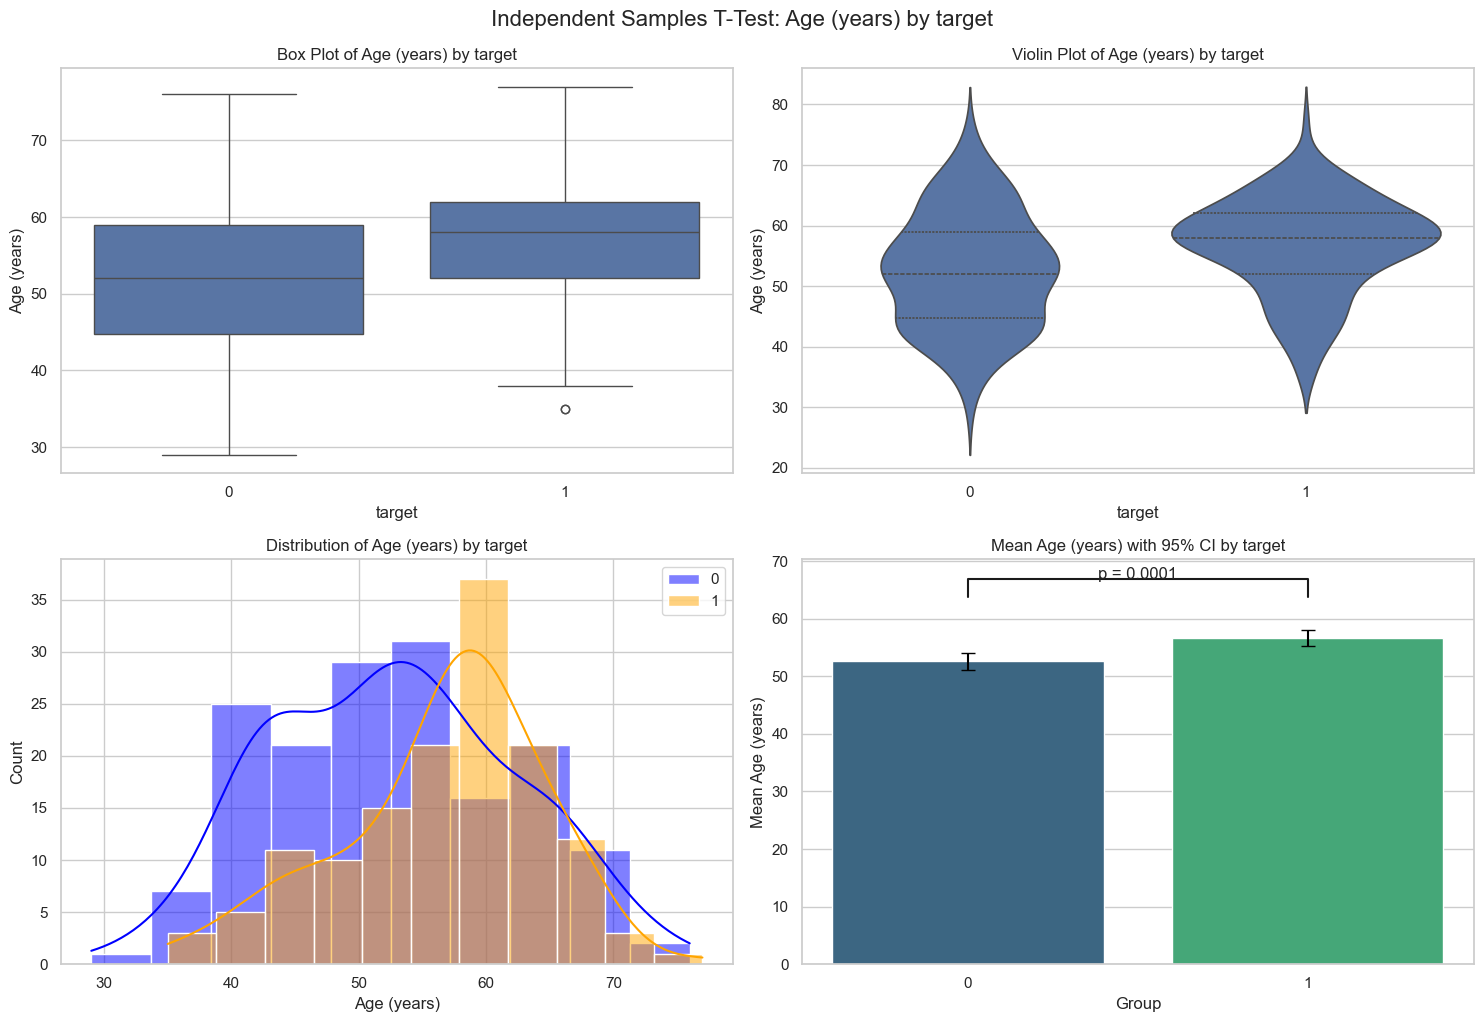


Example 2: Comparing cholesterol levels between patients with and without heart disease


Checking homogeneity of variance assumption:
  Levene's test p-value: 0.7032
  Variances are equal
  Using Student's t-test (equal variances)

Independent Samples T-Test Results:
  Comparing Cholesterol (mg/dl) between 0 and 1
  0: Mean = 242.64, SD = 53.46, n = 164
  1: Mean = 251.47, SD = 49.49, n = 139
  Mean difference: 8.83, 95% CI [-2.89, 20.56]
  t(301.0) = -1.4829, p = 0.1391
  Cohen's d = 0.1710 (negligible effect)
  Result: No statistically significant difference in Cholesterol (mg/dl) between groups
  Statistical power: 0.3153
  Required sample size per group for 80% power: 539


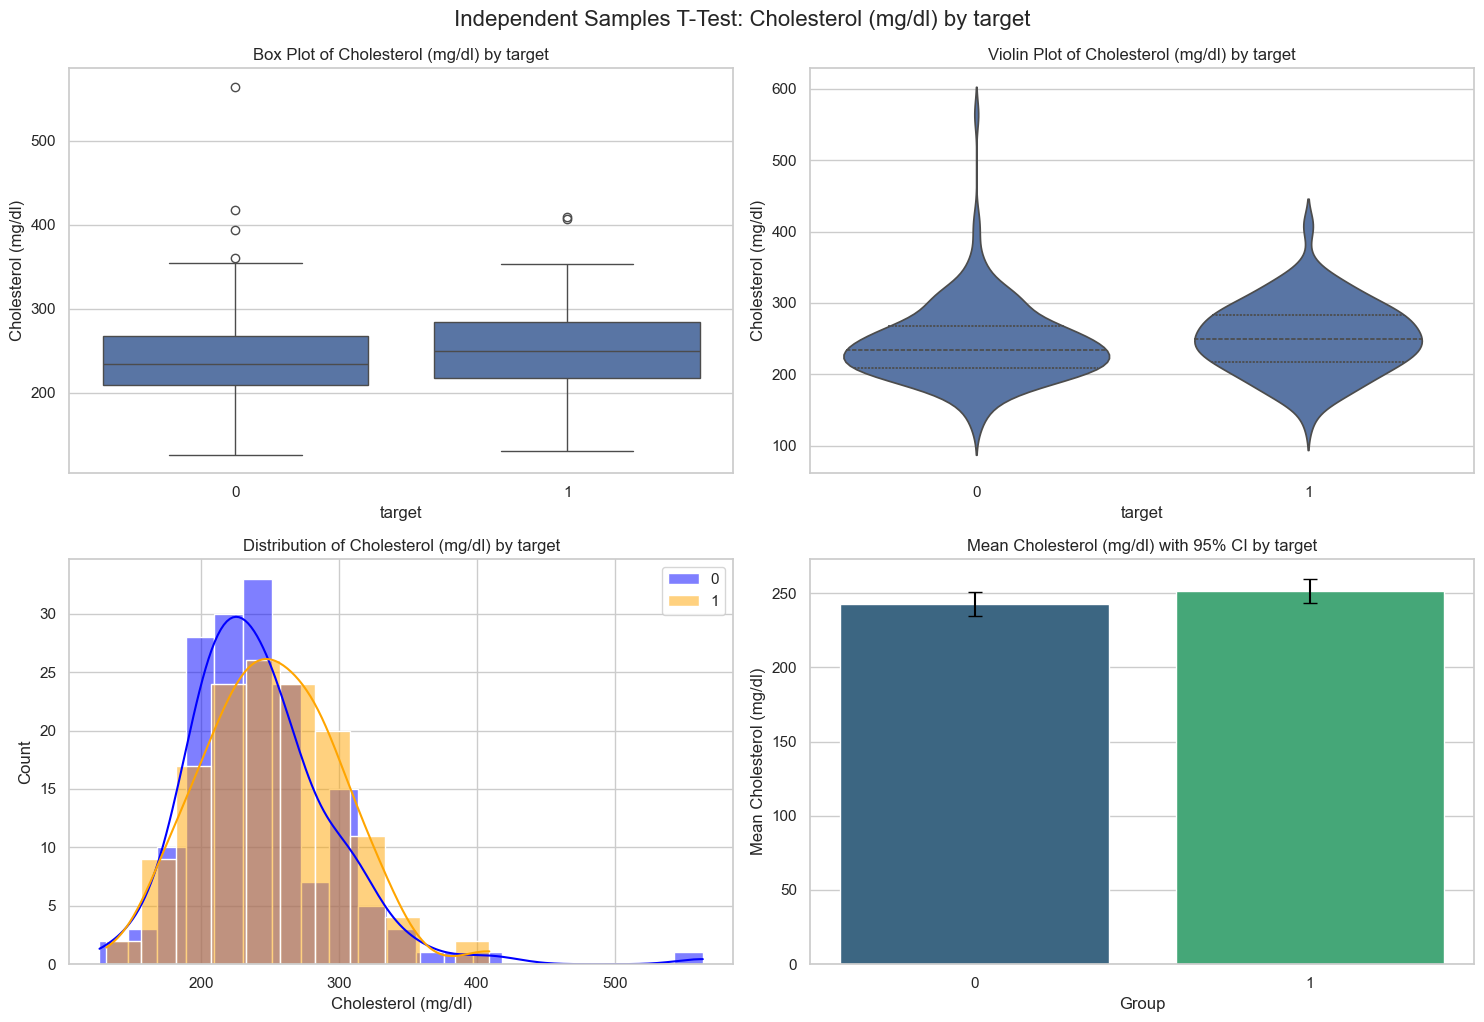


Example 3: Comparing maximum heart rate achieved between patients with and without heart disease


Checking homogeneity of variance assumption:
  Levene's test p-value: 0.0230
  Variances are not equal
  Using Welch's t-test (unequal variances)

Independent Samples T-Test Results:
  Comparing Maximum Heart Rate between 0 and 1
  0: Mean = 158.38, SD = 19.20, n = 164
  1: Mean = 139.26, SD = 22.59, n = 139
  Mean difference: -19.12, 95% CI [-23.91, -14.33]
  t(272.3) = 7.8579, p = 0.0000
  Cohen's d = -0.9120 (large effect)
  Result: Statistically significant difference in Maximum Heart Rate between groups
  Statistical power: 1.0000


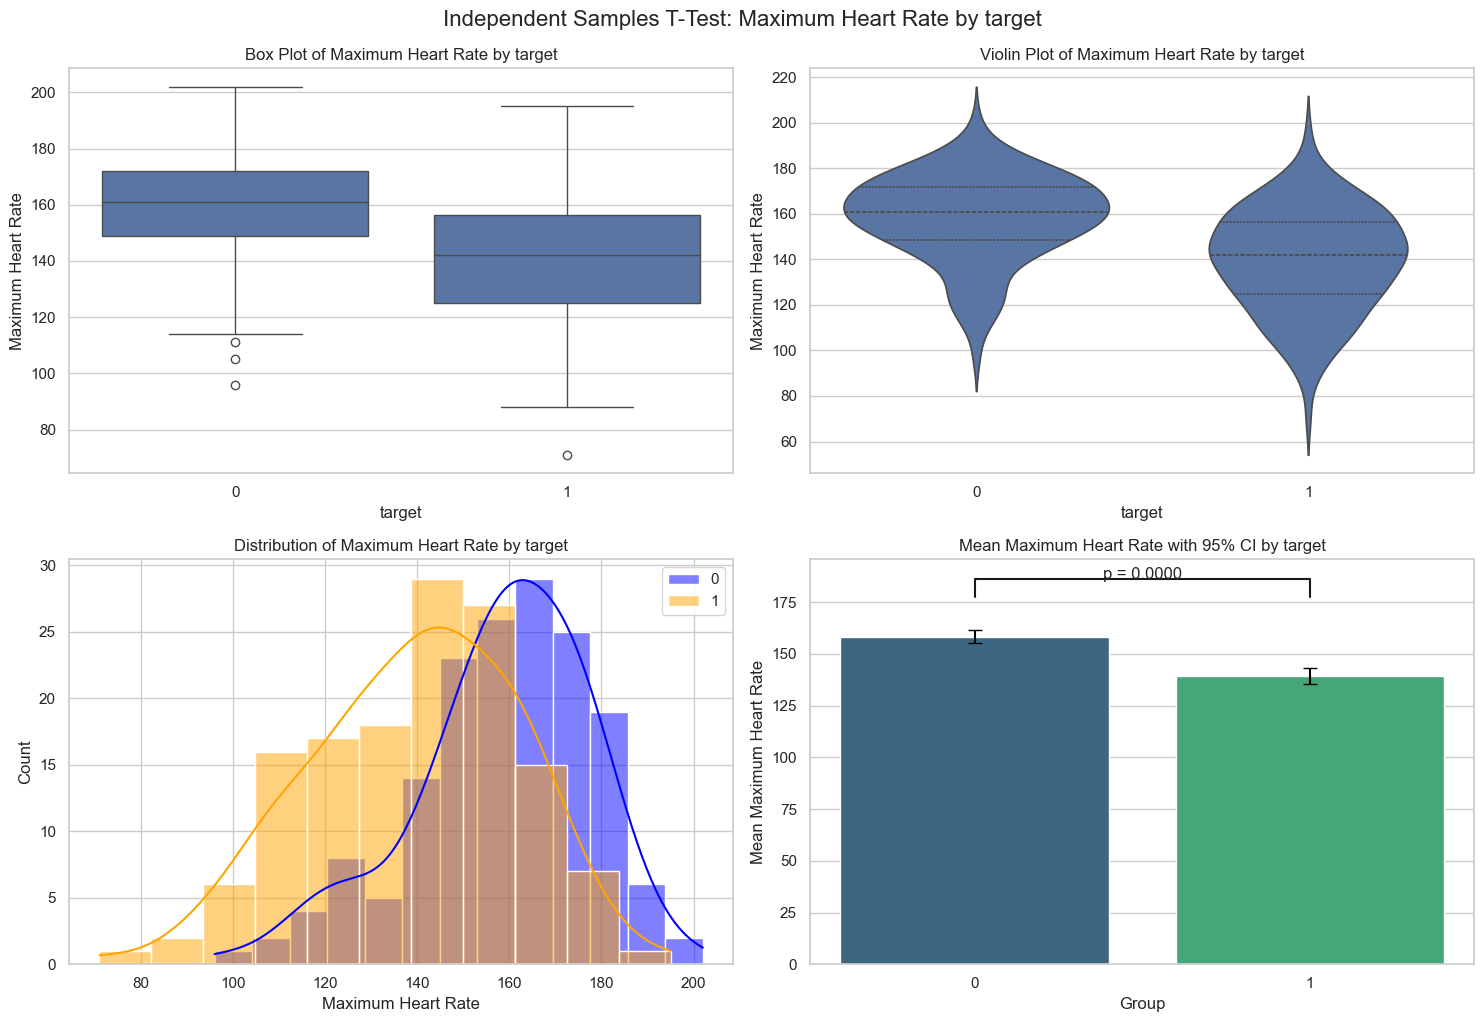

In [9]:
def perform_independent_ttest(data, group_var, test_var, display_name=None, equal_var=True):
    """
    Perform an independent samples t-test and visualize the results.
    For example, compare age by target or cholesterol by target

    Parameters:
    -----------
    data : pandas.DataFrame - The dataset
    group_var : The column name for the grouping variable (In our case, target - heart disease or no heart disease)
    test_var : The column name for the test variable (what we're comparing). In our case age, or cholesterol, etc.
    display_name : str, optional - A more readable name for the test variable (for plotting). e.g., Cholesterol (mg/dl)
    equal_var : bool, default=True - Whether to assume equal variances
    """
    if display_name is None:
        display_name = test_var

    # Split the data into two groups
    group_values = data[group_var].unique()
    if len(group_values) != 2:
        print(f"Error: {group_var} must have exactly 2 unique values for t-test.")
        return

    group1 = data[data[group_var] == group_values[0]][test_var].dropna()
    group2 = data[data[group_var] == group_values[1]][test_var].dropna()



    # Check homogeneity of variance assumption
    _, p_levene = stats.levene(group1, group2)
    print(f"\nChecking homogeneity of variance assumption:")
    print(f"  Levene's test p-value: {p_levene:.4f}")
    print(f"  Variances are {'equal' if p_levene > 0.05 else 'not equal'}")

    # Decide whether to use equal variance assumption based on Levene's test
    if p_levene < 0.05:
        equal_var = False
        print("  Using Welch's t-test (unequal variances)")
    else:
        print("  Using Student's t-test (equal variances)")

    # Perform the t-test
    t_stat, p_value = stats.ttest_ind(group1, group2, equal_var=equal_var)

    # Calculate descriptive statistics
    mean1, std1 = group1.mean(), group1.std()
    mean2, std2 = group2.mean(), group2.std()
    n1, n2 = len(group1), len(group2)

    # Calculate effect size (Cohen's d)
    if equal_var:
        # Pooled standard deviation
        s_pooled = np.sqrt(((n1 - 1) * std1**2 + (n2 - 1) * std2**2) / (n1 + n2 - 2))
        d = (mean2 - mean1) / s_pooled
    else:
        # For Welch's t-test, use average standard deviation
        d = (mean2 - mean1) / np.sqrt((std1**2 + std2**2) / 2)

    # Interpret effect size
    if abs(d) < 0.2:
        d_interpretation = "negligible"
    elif abs(d) < 0.5:
        d_interpretation = "small"
    elif abs(d) < 0.8:
        d_interpretation = "medium"
    else:
        d_interpretation = "large"

    # Calculate confidence interval for the mean difference
    if equal_var:
        dof = n1 + n2 - 2
    else:
        # Calculate Welch-Satterthwaite equation for degrees of freedom
        # This is the correct way to calculate df for Welch's t-test
        dof = ((std1**2/n1 + std2**2/n2)**2) / \
              ((std1**4/(n1**2*(n1-1)) + std2**4/(n2**2*(n2-1))))

    mean_diff = mean2 - mean1

    # Standard error of the difference between means
    if equal_var:
        se_diff = s_pooled * np.sqrt(1/n1 + 1/n2)
    else:
        se_diff = np.sqrt(std1**2/n1 + std2**2/n2)

    # Calculate 95% confidence interval
    t_crit = stats.t.ppf(0.975, dof)  # 95% confidence interval
    ci_lower = mean_diff - t_crit * se_diff
    ci_upper = mean_diff + t_crit * se_diff

    # Print results
    print("\nIndependent Samples T-Test Results:")
    print(f"  Comparing {display_name} between {group_values[0]} and {group_values[1]}")
    print(f"  {group_values[0]}: Mean = {mean1:.2f}, SD = {std1:.2f}, n = {n1}")
    print(f"  {group_values[1]}: Mean = {mean2:.2f}, SD = {std2:.2f}, n = {n2}")
    print(f"  Mean difference: {mean_diff:.2f}, 95% CI [{ci_lower:.2f}, {ci_upper:.2f}]")
    print(f"  t({dof:.1f}) = {t_stat:.4f}, p = {p_value:.4f}")
    print(f"  Cohen's d = {d:.4f} ({d_interpretation} effect)")

    if p_value < 0.05:
        print(f"  Result: Statistically significant difference in {display_name} between groups")
    else:
        print(f"  Result: No statistically significant difference in {display_name} between groups")

    # Calculate power
    power_analysis = TTestIndPower()
    power = power_analysis.power(effect_size=abs(d), nobs1=n1, alpha=0.05, ratio=n2/n1)
    print(f"  Statistical power: {power:.4f}")

    if power < 0.8:
        print(f"  Warning: Low statistical power. Sample size might be too small to detect the effect.")
        # Calculate required sample size for 80% power
        required_n = power_analysis.solve_power(effect_size=abs(d), power=0.8, alpha=0.05, ratio=1)
        print(f"  Required sample size per group for 80% power: {int(np.ceil(required_n))}")

    # Create visualizations
    plt.figure(figsize=(15, 10))

    # 1. Box plots
    plt.subplot(2, 2, 1)
    sns.boxplot(x=group_var, y=test_var, data=data)
    plt.title(f'Box Plot of {display_name} by {group_var}')
    plt.ylabel(display_name)

    # 2. Violin plots
    plt.subplot(2, 2, 2)
    sns.violinplot(x=group_var, y=test_var, data=data, inner='quartile')
    plt.title(f'Violin Plot of {display_name} by {group_var}')
    plt.ylabel(display_name)

    # 3. Histogram for each group
    plt.subplot(2, 2, 3)
    sns.histplot(group1, color='blue', alpha=0.5, label=group_values[0], kde=True)
    sns.histplot(group2, color='orange', alpha=0.5, label=group_values[1], kde=True)
    plt.title(f'Distribution of {display_name} by {group_var}')
    plt.xlabel(display_name)
    plt.legend()

    # 4. Bar plot with error bars
    plt.subplot(2, 2, 4)

    # Create data for bar plot
    bar_data = pd.DataFrame({
        'Group': [group_values[0], group_values[1]],
        'Mean': [mean1, mean2],
        'SD': [std1, std2],
        'SE': [std1/np.sqrt(n1), std2/np.sqrt(n2)],
        'CI_lower': [mean1 - t_crit * std1/np.sqrt(n1), mean2 - t_crit * std2/np.sqrt(n2)],
        'CI_upper': [mean1 + t_crit * std1/np.sqrt(n1), mean2 + t_crit * std2/np.sqrt(n2)]
    })

    # Plot bars
    sns.barplot(x='Group', y='Mean', data=bar_data, palette='viridis')

    # Add error bars (95% confidence intervals)
    plt.errorbar(x=range(len(bar_data)), y=bar_data['Mean'],
                yerr=[(bar_data['Mean'] - bar_data['CI_lower']).values,
                     (bar_data['CI_upper'] - bar_data['Mean']).values],
                fmt='none', c='black', capsize=5)

    plt.title(f'Mean {display_name} with 95% CI by {group_var}')
    plt.ylabel(f'Mean {display_name}')

    # Add significance annotation if appropriate
    if p_value < 0.05:
        max_y = max(bar_data['CI_upper']) * 1.1
        plt.plot([0, 0, 1, 1], [max_y, max_y + 0.05*max_y, max_y + 0.05*max_y, max_y], 'k-')
        plt.text(0.5, max_y + 0.05*max_y, f'p = {p_value:.4f}', ha='center')

    plt.tight_layout()
    plt.suptitle(f'Independent Samples T-Test: {display_name} by {group_var}', fontsize=16, y=1.02)
    plt.show()

    # Return the results for further analysis if needed
    return {
        't_statistic': t_stat,
        'p_value': p_value,
        'cohens_d': d,
        'mean_difference': mean_diff,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'power': power
    }

# Perform independent t-test for age by heart disease status
print("Example 1: Comparing age between patients with and without heart disease\n")
age_results = perform_independent_ttest(heart_data, 'target', 'age', 'Age (years)', equal_var=True)

# Perform independent t-test for cholesterol by heart disease status
print("\nExample 2: Comparing cholesterol levels between patients with and without heart disease\n")
chol_results = perform_independent_ttest(heart_data, 'target', 'chol', 'Cholesterol (mg/dl)', equal_var=True)

# Perform independent t-test for maximum heart rate by heart disease status
print("\nExample 3: Comparing maximum heart rate achieved between patients with and without heart disease\n")
hr_results = perform_independent_ttest(heart_data, 'target', 'thalach', 'Maximum Heart Rate', equal_var=True)

# 4. Paired t-test

Now let us look at how to perform a paired t-test. Since our heart disease dataset does not include "before and after" measurements for the same individuals, we will simulate data for demonstration.

We’ll generate artificial blood pressure values before and after a treatment. The idea is to test whether there is a statistically significant change in blood pressure after the intervention.

**Data Simulation:**
We simulate “before treatment” blood pressure readings with a mean of 140 and standard deviation of 15. For the “after treatment” values, we simulate data with a slightly lower mean (135) and make it correlated to the “before” values to reflect paired observations (same individuals measured twice).

**Normality Check:**
Since the paired t-test assumes that the differences between the paired values are normally distributed, we check this assumption using the Shapiro-Wilk test.

**Paired t-test:**
If the assumption holds, we run the paired t-test, which compares the mean values before and after the intervention. This helps us determine if any observed difference is statistically significant.

**Effect Size:**
We also calculate Cohen’s d, a measure of how strong the difference is. This gives more insight than p-values alone by indicating whether the observed change is small, medium, or large.

**Confidence Interval:**
A 95% confidence interval is computed for the mean difference to show the range in which the true difference likely falls.

**Statistical Power:**
We estimate the power of the test — how likely it is to detect a true effect if it exists. If power is low (typically < 0.8), we calculate how many subjects would be needed to achieve reliable results.

**Visualization:**
Multiple plots help communicate the findings:

A box plot to show the spread of values before and after.

A paired line plot to visualize individual-level changes.

A histogram of differences to assess the shape of the distribution.

A bar plot with error bars to show means and 95% confidence intervals, along with significance markers.

Example 4: Comparing blood pressure before and after treatment (simulated data)
Checking normality assumption for the differences in blood_pressure:
  Shapiro-Wilk test p-value: 0.0853
  Distribution of differences is normal

Paired Samples T-Test Results:
  Comparing Blood Pressure (mmHg) before and after
  Before: Mean = 138.44, SD = 13.62
  After: Mean = 135.21, SD = 16.55
  Mean difference (After - Before): -3.23, 95% CI [-5.50, -0.96]
  t(99) = 2.8245, p = 0.0057
  Cohen's d = -0.2824 (small effect)
  Result: Statistically significant change in Blood Pressure (mmHg)
  Statistical power: 0.7987
  Required sample size for 80% power: 101


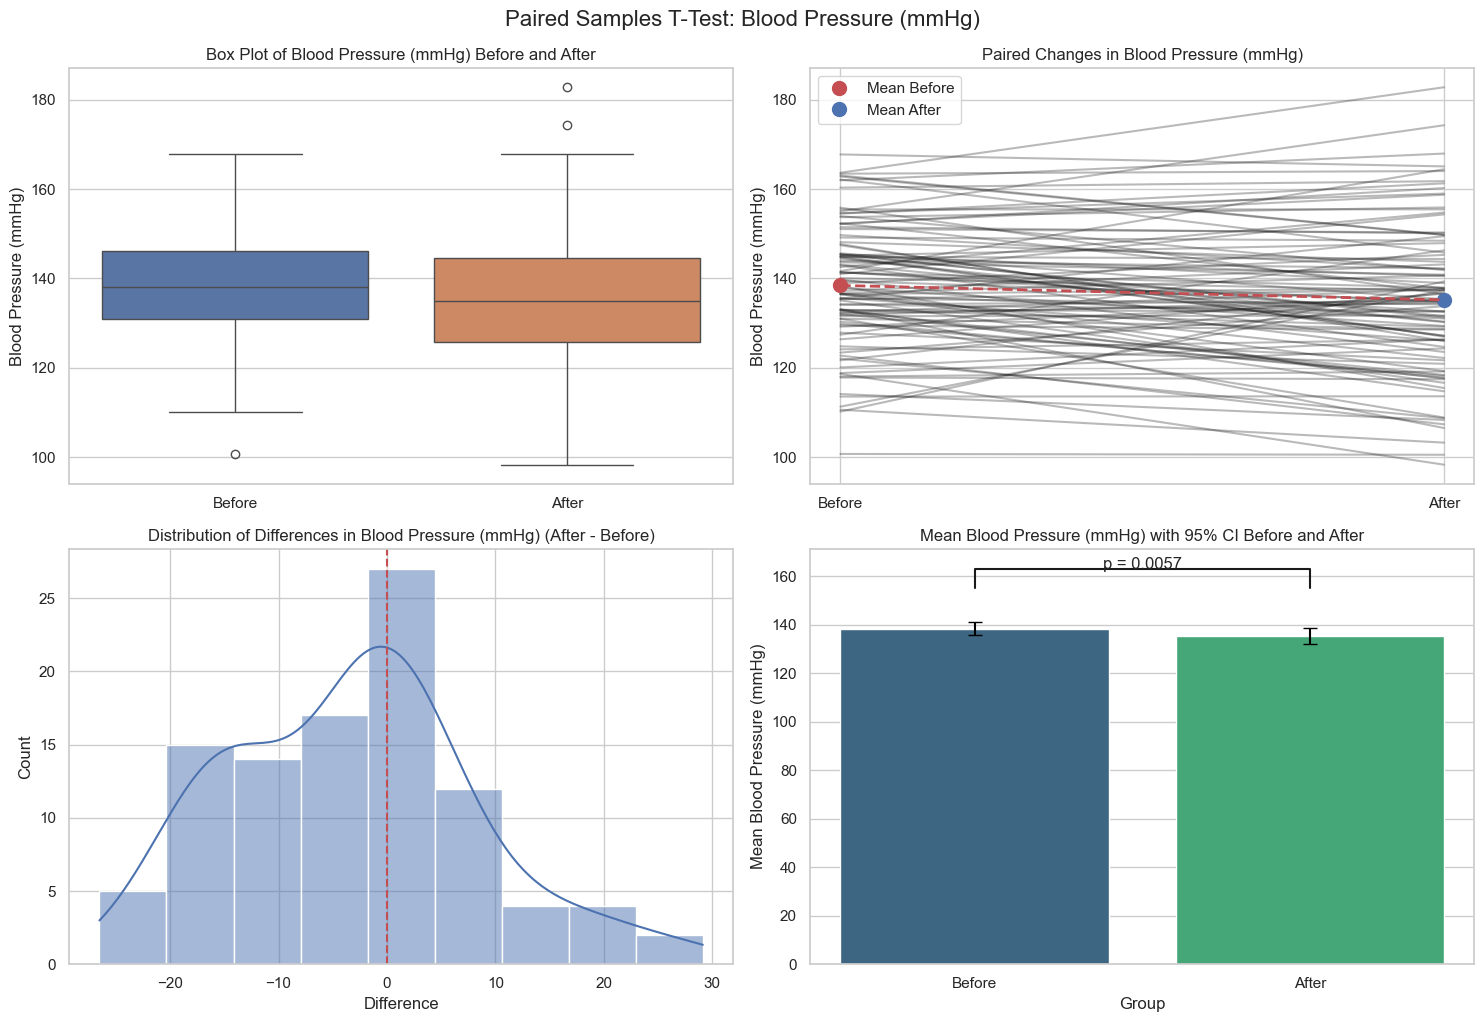

In [10]:
def perform_paired_ttest(before_data, after_data, var_name, display_name=None):
    """
    Perform a paired samples t-test and visualize the results.

    Parameters:
    -----------
    before_data : array-like
        Data before treatment/intervention
    after_data : array-like
        Data after treatment/intervention
    var_name : str
        The name of the variable being tested
    display_name : str, optional
        A more readable name for the variable (for plotting)
    """
    if display_name is None:
        display_name = var_name

    # Make sure data is of equal length
    if len(before_data) != len(after_data):
        print("Error: Before and after data must have the same length")
        return

    # Calculate differences
    diff = after_data - before_data

    # Check normality of differences
    _, p_shapiro = stats.shapiro(diff)
    print(f"Checking normality assumption for the differences in {var_name}:")
    print(f"  Shapiro-Wilk test p-value: {p_shapiro:.4f}")
    print(f"  Distribution of differences is {'normal' if p_shapiro > 0.05 else 'non-normal'}")

    # Perform the paired t-test
    t_stat, p_value = stats.ttest_rel(before_data, after_data)

    # Calculate descriptive statistics
    mean_before, std_before = np.mean(before_data), np.std(before_data, ddof=1)
    mean_after, std_after = np.mean(after_data), np.std(after_data, ddof=1)
    mean_diff = mean_after - mean_before
    std_diff = np.std(diff, ddof=1)
    n = len(before_data)

    # Calculate effect size (Cohen's d for paired samples)
    d = mean_diff / std_diff

    # Interpret effect size
    if abs(d) < 0.2:
        d_interpretation = "negligible"
    elif abs(d) < 0.5:
        d_interpretation = "small"
    elif abs(d) < 0.8:
        d_interpretation = "medium"
    else:
        d_interpretation = "large"

    # Calculate 95% confidence interval for the mean difference
    se_diff = std_diff / np.sqrt(n)
    t_crit = stats.t.ppf(0.975, n-1)  # 95% confidence interval
    ci_lower = mean_diff - t_crit * se_diff
    ci_upper = mean_diff + t_crit * se_diff

    # Print results
    print("\nPaired Samples T-Test Results:")
    print(f"  Comparing {display_name} before and after")
    print(f"  Before: Mean = {mean_before:.2f}, SD = {std_before:.2f}")
    print(f"  After: Mean = {mean_after:.2f}, SD = {std_after:.2f}")
    print(f"  Mean difference (After - Before): {mean_diff:.2f}, 95% CI [{ci_lower:.2f}, {ci_upper:.2f}]")
    print(f"  t({n-1}) = {t_stat:.4f}, p = {p_value:.4f}")
    print(f"  Cohen's d = {d:.4f} ({d_interpretation} effect)")

    if p_value < 0.05:
        print(f"  Result: Statistically significant change in {display_name}")
    else:
        print(f"  Result: No statistically significant change in {display_name}")

    # Calculate power
    power_analysis = TTestPower()
    power = power_analysis.power(effect_size=abs(d), nobs=n, alpha=0.05)
    print(f"  Statistical power: {power:.4f}")

    if power < 0.8:
        print(f"  Warning: Low statistical power. Sample size might be too small to detect the effect.")
        # Calculate required sample size for 80% power
        required_n = power_analysis.solve_power(effect_size=abs(d), power=0.8, alpha=0.05)
        print(f"  Required sample size for 80% power: {int(np.ceil(required_n))}")

    # Create visualizations
    plt.figure(figsize=(15, 10))

    # 1. Box plots
    plt.subplot(2, 2, 1)
    box_data = pd.DataFrame({
        'Before': before_data,
        'After': after_data
    })
    sns.boxplot(data=box_data)
    plt.title(f'Box Plot of {display_name} Before and After')
    plt.ylabel(display_name)

    # 2. Paired plot

    plt.subplot(2, 2, 2)
    for i in range(n):
        plt.plot([1, 2], [before_data[i], after_data[i]], 'k-', alpha=0.3)

    # Add mean points
    plt.plot(1, mean_before, 'ro', markersize=10, label='Mean Before')
    plt.plot(2, mean_after, 'bo', markersize=10, label='Mean After')

    # Connect means
    plt.plot([1, 2], [mean_before, mean_after], 'r--', linewidth=2)

    plt.xticks([1, 2], ['Before', 'After'])
    plt.title(f'Paired Changes in {display_name}')
    plt.ylabel(display_name)
    plt.legend()

    # 3. Histogram of differences
    plt.subplot(2, 2, 3)
    sns.histplot(diff, kde=True)
    plt.axvline(0, color='r', linestyle='--')
    plt.title(f'Distribution of Differences in {display_name} (After - Before)')
    plt.xlabel('Difference')

    # 4. Bar plot with error bars
    plt.subplot(2, 2, 4)

    # Create data for bar plot
    bar_data = pd.DataFrame({
        'Group': ['Before', 'After'],
        'Mean': [mean_before, mean_after],
        'SD': [std_before, std_after],
        'SE': [std_before/np.sqrt(n), std_after/np.sqrt(n)],
        'CI_lower': [mean_before - t_crit * std_before/np.sqrt(n),
                    mean_after - t_crit * std_after/np.sqrt(n)],
        'CI_upper': [mean_before + t_crit * std_before/np.sqrt(n),
                    mean_after + t_crit * std_after/np.sqrt(n)]
    })

    # Plot bars
    sns.barplot(x='Group', y='Mean', data=bar_data, palette='viridis')

    # Add error bars (95% confidence intervals)
    plt.errorbar(x=range(len(bar_data)), y=bar_data['Mean'],
                yerr=[(bar_data['Mean'] - bar_data['CI_lower']).values,
                     (bar_data['CI_upper'] - bar_data['Mean']).values],
                fmt='none', c='black', capsize=5)

    plt.title(f'Mean {display_name} with 95% CI Before and After')
    plt.ylabel(f'Mean {display_name}')

    # Add significance annotation if appropriate
    if p_value < 0.05:
        max_y = max(bar_data['CI_upper']) * 1.1
        plt.plot([0, 0, 1, 1], [max_y, max_y + 0.05*max_y, max_y + 0.05*max_y, max_y], 'k-')
        plt.text(0.5, max_y + 0.05*max_y, f'p = {p_value:.4f}', ha='center')

    plt.tight_layout()
    plt.suptitle(f'Paired Samples T-Test: {display_name}', fontsize=16, y=1.02)
    plt.show()

    # Return the results for further analysis if needed
    return {
        't_statistic': t_stat,
        'p_value': p_value,
        'cohens_d': d,
        'mean_difference': mean_diff,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'power': power
    }

# Since we don't have actual before/after data, let's simulate some blood pressure data
# for demonstration purposes
print("Example 4: Comparing blood pressure before and after treatment (simulated data)")

"""
# Set random seed for reproducibility
np.random.seed(42)

# Simulate before data with mean 140 and SD 15
bp_before = np.random.normal(140, 15, 50)

# Simulate after data with mean 135 and SD 12
# We'll create correlated data to mimic paired observations
correlation = 0.7
bp_after = np.random.normal(135, 12, 50)
bp_after = correlation * bp_before + (1 - correlation) * bp_after
"""

# Set random seed for reproducibility
np.random.seed(42)
num_patients = 100
# Simulate before data with mean 140 and SD 15
bp_before = np.random.normal(140, 15, num_patients)

# Simulate a moderate treatment effect: decrease of ~5 mmHg on average
true_effect = -3.5  # desired average decrease
noise_sd = 20     # realistic post-treatment variation
correlation = 0.4

# Add noise correlated with the before values
random_noise = np.random.normal(0, noise_sd, num_patients)
bp_after = bp_before + true_effect + (1 - correlation) * random_noise

# Run the paired t-test on the simulated blood pressure data
bp_results = perform_paired_ttest(bp_before, bp_after, 'blood_pressure', 'Blood Pressure (mmHg)')



--- CHI-SQUARE TEST FOR CATEGORICAL DATA ---

Example: Testing association between sex and heart disease


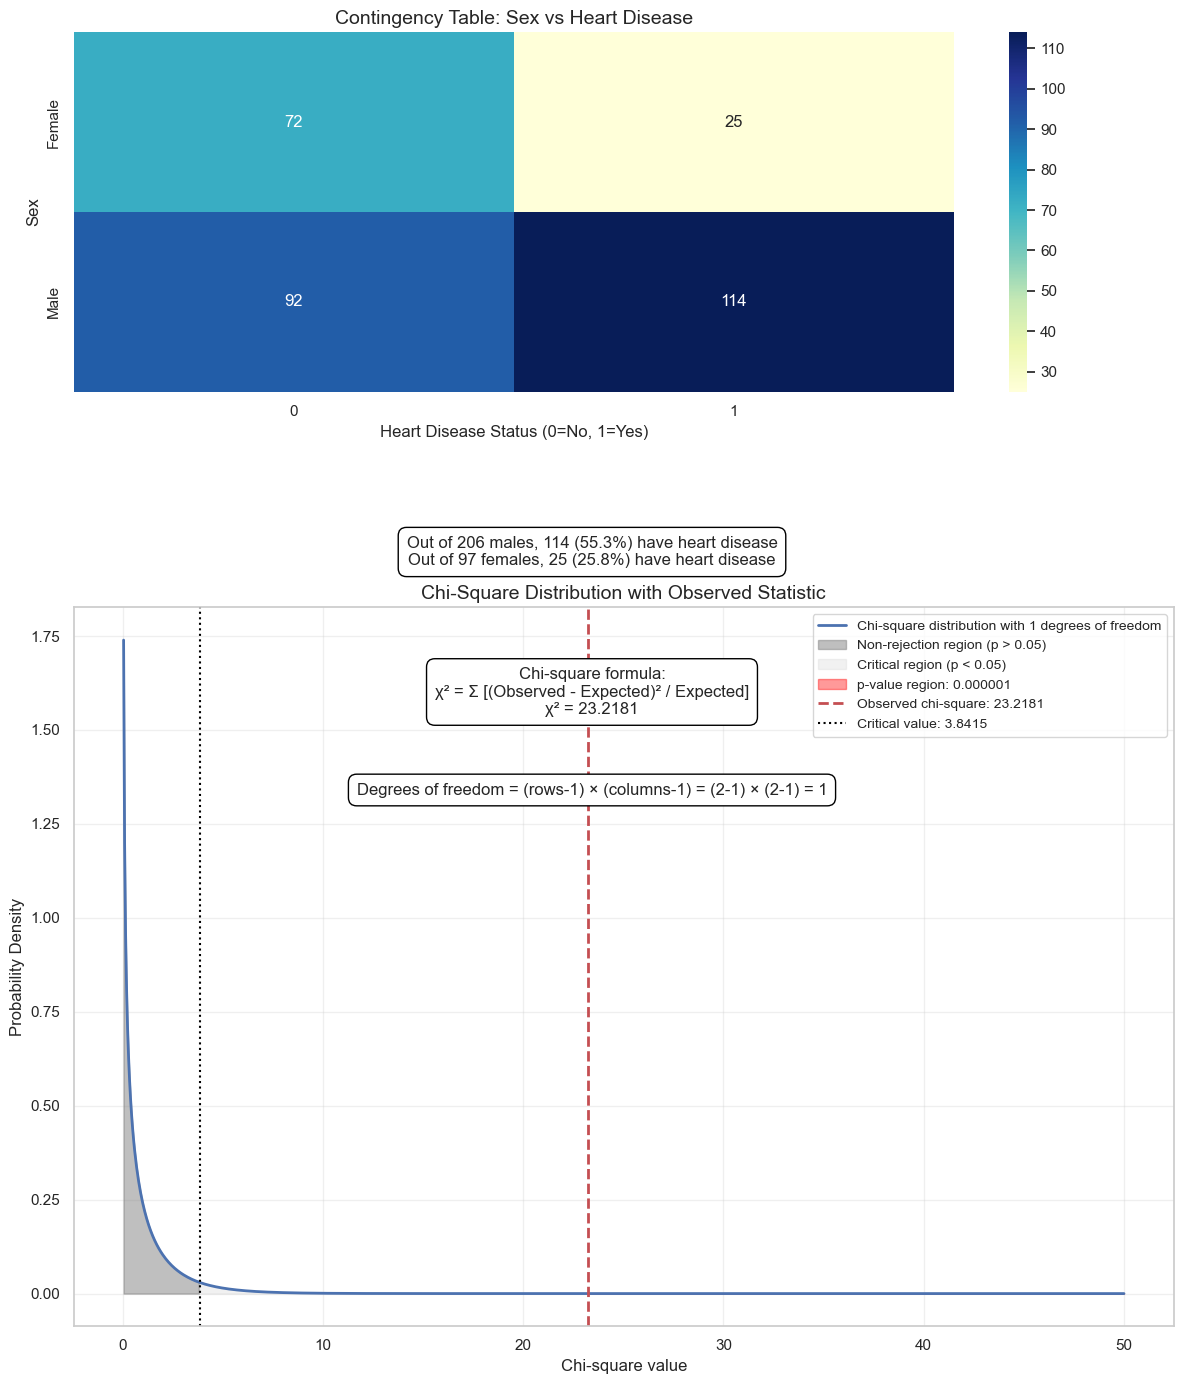


Chi-Square Test Explanation:
- Null hypothesis (H0): There is no association between variables
- Alternative hypothesis (H1): There is an association between variables

Contingency Table (Observed Counts):
target   0    1
sex            
Female  72   25
Male    92  114

Expected Counts (if no association existed):
target      0     1
sex                
Female   52.5  44.5
Male    111.5  94.5

Row Percentages (% within each row):
target      0      1
sex                 
Female  74.23  25.77
Male    44.66  55.34

Chi-square calculation compares observed vs. expected counts:
Chi-square formula: χ² = Σ [(Observed - Expected)² / Expected]
Cell [Female, 0]: (72 - 52.5)² / 52.5 = 7.24
Cell [Female, 1]: (25 - 44.5)² / 44.5 = 8.54
Cell [Male, 0]: (92 - 111.5)² / 111.5 = 3.41
Cell [Male, 1]: (114 - 94.5)² / 94.5 = 4.02
Sum of all components: 23.2181

Results:
- Chi-square statistic: 23.2181
- Degrees of freedom: 1
- p-value: 0.000001
- Since p-value (0.000001) < 0.05, we reject the null hypot

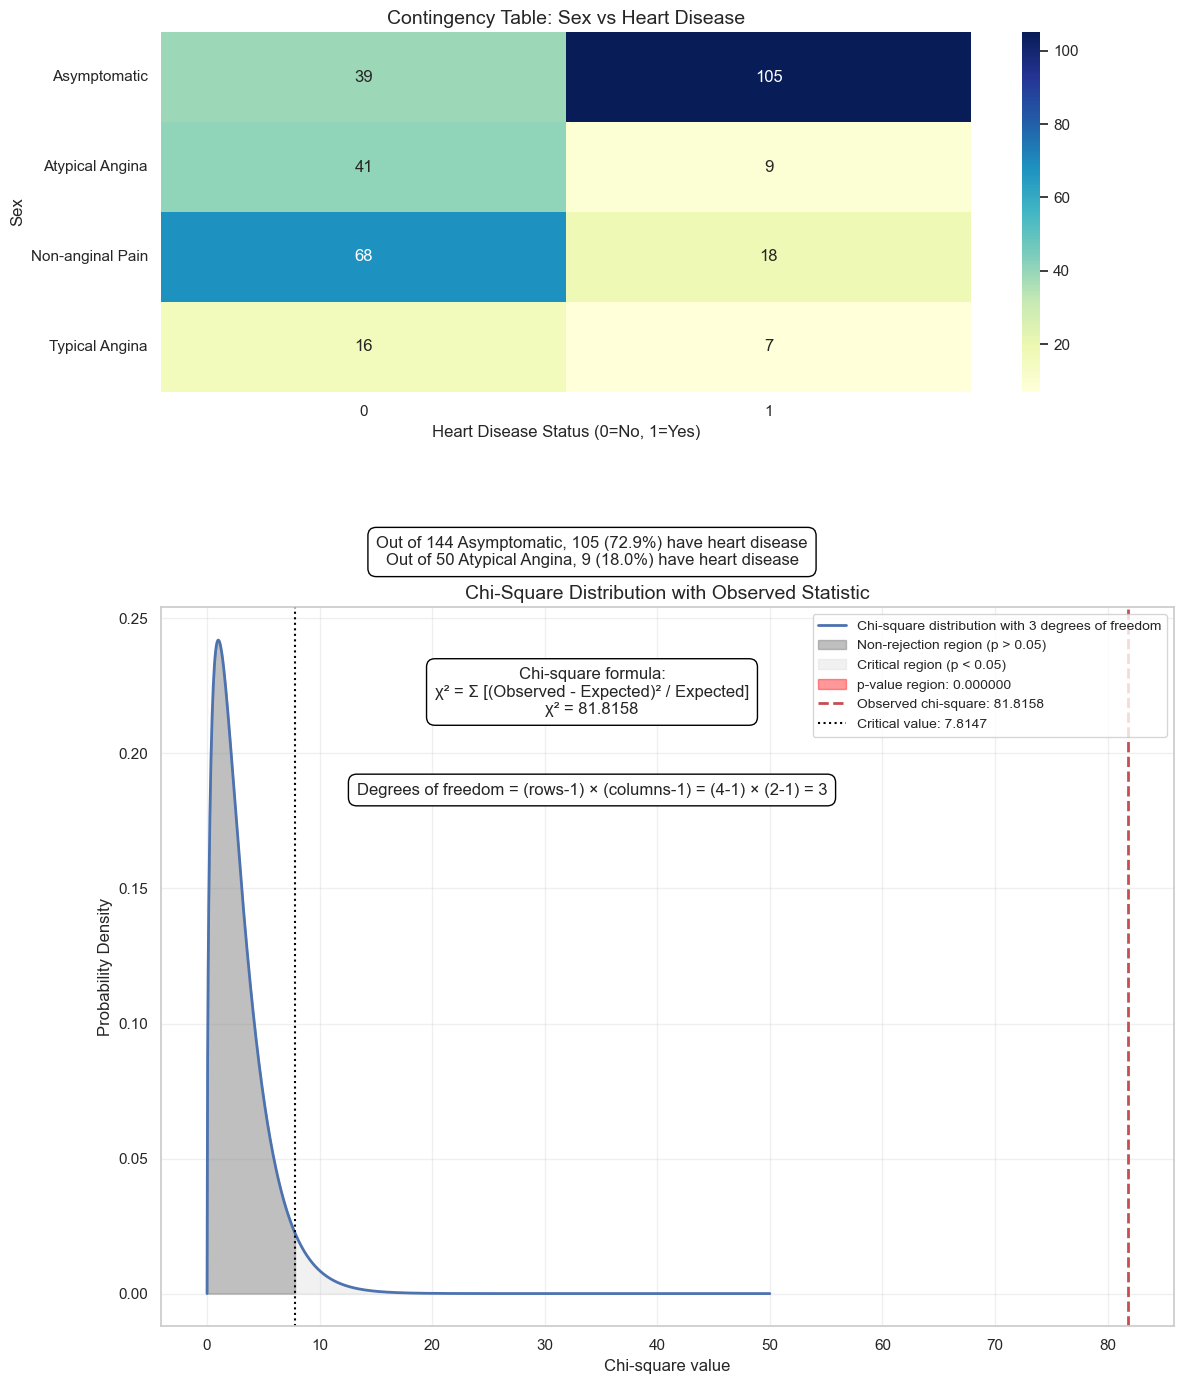


Chi-Square Test Explanation:
- Null hypothesis (H0): There is no association between variables
- Alternative hypothesis (H1): There is an association between variables

Contingency Table (Observed Counts):
target             0    1
cp_cat                   
Asymptomatic      39  105
Atypical Angina   41    9
Non-anginal Pain  68   18
Typical Angina    16    7

Expected Counts (if no association existed):
target                0      1
cp_cat                        
Asymptomatic      77.94  66.06
Atypical Angina   27.06  22.94
Non-anginal Pain  46.55  39.45
Typical Angina    12.45  10.55

Row Percentages (% within each row):
target                0      1
cp_cat                        
Asymptomatic      27.08  72.92
Atypical Angina   82.00  18.00
Non-anginal Pain  79.07  20.93
Typical Angina    69.57  30.43

Chi-square calculation compares observed vs. expected counts:
Chi-square formula: χ² = Σ [(Observed - Expected)² / Expected]
Cell [Asymptomatic, 0]: (39 - 77.9)² / 77.9 = 19.46
Cel

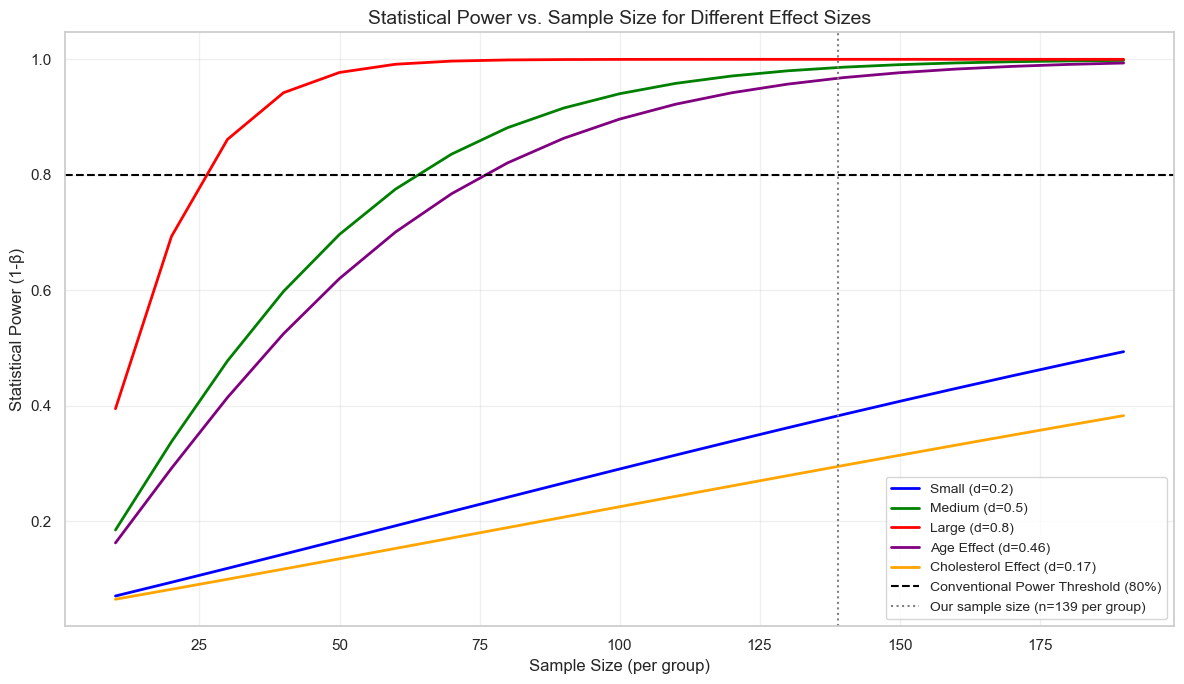


Power Analysis for Our Current Study:
- Age comparison: Power = 0.9772 (97.7%)
  Good: Power exceeds the conventional 80% threshold
- Cholesterol comparison: Power = 0.3153 (31.5%)

Required Sample Size (per group) for 80% Power (α=0.05):
  Small (d=0.2): 394 participants per group
  Medium (d=0.5): 64 participants per group
  Large (d=0.8): 26 participants per group
  Age Effect (d=0.46): 76 participants per group
  Cholesterol Effect (d=0.17): 539 participants per group

Trade-offs in Power Analysis:
1. Increasing sample size → Increases power but requires more resources
2. Larger effect sizes → Easier to detect (higher power)
3. Increasing alpha level (e.g., from 0.05 to 0.10) → Increases power but also increases Type I error risk
4. More precise measurements → Reduces variability, increasing power

Relationship between Errors and Decision Thresholds:
  Type I Error (α): Probability of falsely rejecting a true null hypothesis
  Type II Error (β): Probability of falsely accepting a 

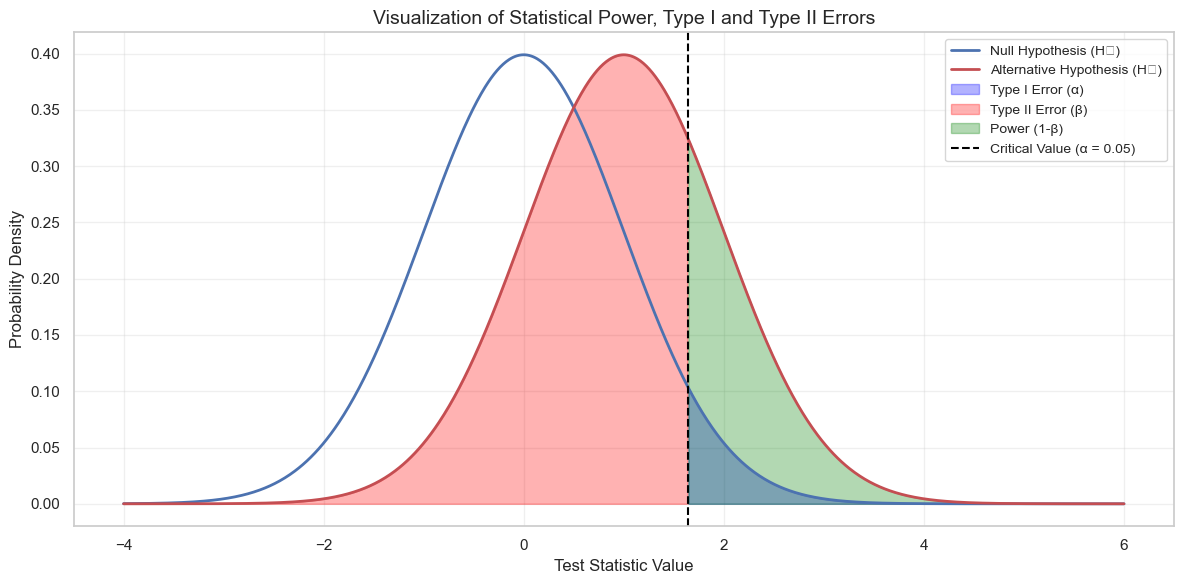

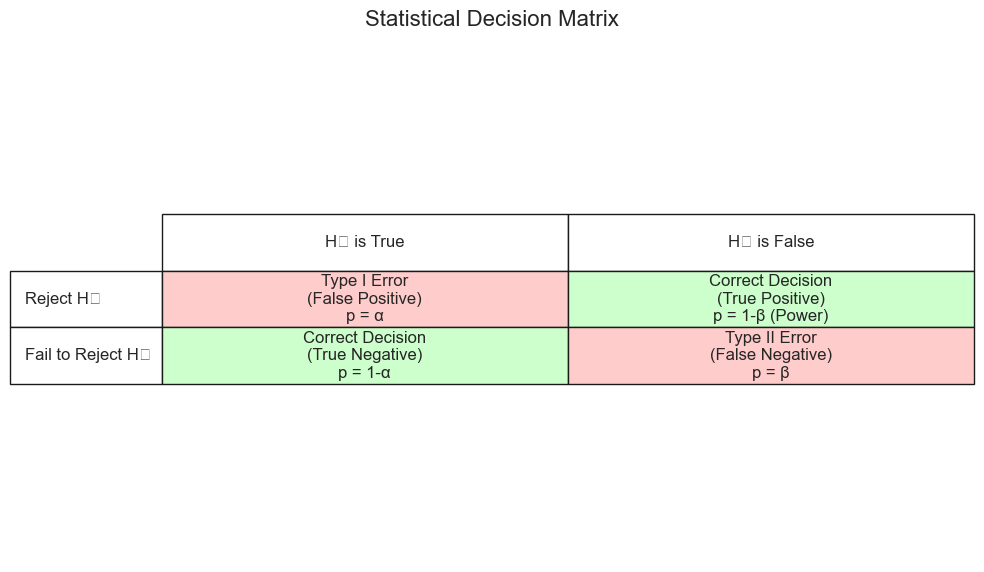


Key Points about Effect Size and Power:
1. Statistical significance (p < .05) does not indicate practical significance
2. Effect size quantifies the magnitude of the difference or relationship
3. Larger sample sizes can detect smaller effects (but consider practical importance)
4. Low-powered studies may miss true effects or exaggerate effect sizes when significant
5. Good practice: Plan sample size based on the smallest effect size of practical importance


--- CONCLUSION AND KEY TAKEAWAYS ---

Key Takeaways from Comparing Two Groups:

1. Hypothesis Testing Framework:
   - Null hypothesis testing provides a systematic approach to evaluate group differences
   - p-values indicate compatibility with the null hypothesis, not the probability it's true
   - Statistical significance (p < .05) does not automatically imply practical importance

2. Independent vs. Paired Tests:
   - Independent t-test: Use when comparing unrelated groups
   - Paired t-test: Use when comparing related/matched 

In [11]:



# -------------------------
# 5. Chi-Square Test
# -------------------------

print("\n\n--- CHI-SQUARE TEST FOR CATEGORICAL DATA ---\n")

def visualize_chi_square_test_detailed(contingency_table, alpha=0.05):
    """
    Visualize chi-square test with both the contingency table and theoretical chi-square distribution
    using a detailed approach with the actual heart disease dataset.

    Parameters:
    -----------
    contingency_table : pandas.DataFrame
        2x2 contingency table of observed frequencies
    alpha : float, default=0.05
        Significance level
    """
    # Calculate chi-square statistic and p-value
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table, correction=False)  #Can disable Yates' continuity correction.

    # Create a figure with 2 subplots with more space
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 14), gridspec_kw={'height_ratios': [1, 2]})

    # Plot 1: Contingency table as a heatmap
    sns.heatmap(contingency_table, annot=True, fmt='d', cmap='YlGnBu', ax=ax1)
    ax1.set_title('Contingency Table: Sex vs Heart Disease', fontsize=14)
    ax1.set_xlabel('Heart Disease Status (0=No, 1=Yes)', fontsize=12)
    ax1.set_ylabel('Sex', fontsize=12)

    # Calculate percentages within each sex
    row_percentages = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

    # Create percentage text strings
    row_names = contingency_table.index

    # Handle differently named indices if necessary
    if 'Male' in contingency_table.index and 'Female' in contingency_table.index:
        total_males = contingency_table.loc['Male'].sum()
        total_females = contingency_table.loc['Female'].sum()
        male_disease_pct = row_percentages.loc['Male', 1]
        female_disease_pct = row_percentages.loc['Female', 1]

        # Text box for contingency table explanation
        explanation = (f"Out of {total_males} males, {contingency_table.loc['Male', 1]} ({male_disease_pct:.1f}%) have heart disease\n"
                      f"Out of {total_females} females, {contingency_table.loc['Female', 1]} ({female_disease_pct:.1f}%) have heart disease")
    else:
        # Generic version for any 2x2 table
        row1, row2 = contingency_table.index[0], contingency_table.index[1]
        total_row1 = contingency_table.loc[row1].sum()
        total_row2 = contingency_table.loc[row2].sum()
        row1_col1_pct = row_percentages.loc[row1, 1]
        row2_col1_pct = row_percentages.loc[row2, 1]

        explanation = (f"Out of {total_row1} {row1}, {contingency_table.loc[row1, 1]} ({row1_col1_pct:.1f}%) have heart disease\n"
                      f"Out of {total_row2} {row2}, {contingency_table.loc[row2, 1]} ({row2_col1_pct:.1f}%) have heart disease")

    # Add text below the first subplot but above the second subplot
    plt.figtext(0.5, 0.6, explanation, ha='center', va='center', fontsize=12,
               bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="black", lw=1))

    # Plot 2: Chi-square distribution
    x = np.linspace(0, 50, 1000)
    y = stats.chi2.pdf(x, dof)

    # Plot the chi-square distribution
    ax2.plot(x, y, 'b-', lw=2, label=f'Chi-square distribution with {dof} degrees of freedom')

    # Fill the non-rejection region
    chi2_crit = stats.chi2.ppf(1-alpha, dof)
    ax2.fill_between(x, y, where=(x <= chi2_crit), color='gray', alpha=0.5,
                    label=f'Non-rejection region (p > {alpha})')

    # Fill the rejection region
    ax2.fill_between(x, y, where=(x >= chi2_crit), color='lightgray', alpha=0.3,
                    label=f'Critical region (p < {alpha})')

    # Fill the observed p-value region
    ax2.fill_between(x, y, where=(x >= chi2), color='red', alpha=0.4,
                   label=f'p-value region: {p:.6f}')

    # Add vertical lines for observed chi-square statistic
    ax2.axvline(chi2, color='r', linestyle='--', lw=2,
               label=f'Observed chi-square: {chi2:.4f}')

    # Add critical value line
    ax2.axvline(chi2_crit, color='black', linestyle=':', lw=1.5,
              label=f'Critical value: {chi2_crit:.4f}')

    # Add labels and legend
    ax2.set_title("Chi-Square Distribution with Observed Statistic", fontsize=14)
    ax2.set_xlabel('Chi-square value', fontsize=12)
    ax2.set_ylabel('Probability Density', fontsize=12)
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc='upper right', fontsize=10)

    # Add chi-square formula in a text box
    chi_formula = (f"Chi-square formula:\nχ² = Σ [(Observed - Expected)² / Expected]\nχ² = {chi2:.4f}")

    # Position the formula box
    plt.figtext(0.5, 0.5, chi_formula, ha='center', va='center', fontsize=12,
               bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="black", lw=1))

    # Explain degrees of freedom with a separate text box
    dof_explanation = (f"Degrees of freedom = (rows-1) × (columns-1) = ({len(contingency_table.index)}-1) × ({len(contingency_table.columns)}-1) = {dof}")

    # Position the degrees of freedom box
    plt.figtext(0.5, 0.43, dof_explanation, ha='center', va='center', fontsize=12,
               bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="black", lw=1))

    # Add more space between subplots and adjust layout
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.4)
    plt.show()

    # Calculate expected values for explanation
    expected_table = pd.DataFrame(expected,
                                 index=contingency_table.index,
                                 columns=contingency_table.columns)

    # Print comprehensive explanation
    print("\nChi-Square Test Explanation:")
    print("- Null hypothesis (H0): There is no association between variables")
    print("- Alternative hypothesis (H1): There is an association between variables")
    print("\nContingency Table (Observed Counts):")
    print(contingency_table)

    print("\nExpected Counts (if no association existed):")
    print(expected_table.round(2))

    print("\nRow Percentages (% within each row):")
    print(row_percentages.round(2))

    print("\nChi-square calculation compares observed vs. expected counts:")
    print("Chi-square formula: χ² = Σ [(Observed - Expected)² / Expected]")

    # Show calculation details
    chi2_components = np.zeros(shape=expected.shape)
    for i in range(expected.shape[0]):
        for j in range(expected.shape[1]):
            observed = contingency_table.iloc[i, j]
            exp = expected[i, j]
            chi2_components[i, j] = ((observed - exp) ** 2) / exp
            print(f"Cell [{contingency_table.index[i]}, {contingency_table.columns[j]}]: ({observed} - {exp:.1f})² / {exp:.1f} = {chi2_components[i, j]:.2f}")

    print(f"Sum of all components: {np.sum(chi2_components):.4f}")
    print(f"\nResults:")
    print(f"- Chi-square statistic: {chi2:.4f}")
    print(f"- Degrees of freedom: {dof}")
    print(f"- p-value: {p:.6f}")

    if p < alpha:
        print(f"- Since p-value ({p:.6f}) < {alpha}, we reject the null hypothesis")
        print(f"- Conclusion: There is a statistically significant association between variables")
    else:
        print(f"- Since p-value ({p:.6f}) > {alpha}, we fail to reject the null hypothesis")
        print(f"- Conclusion: There is not enough evidence to claim a significant association")

    # Return the results
    return chi2, p, dof

# Perform chi-square test for sex and heart disease with detailed explanation
print("Example: Testing association between sex and heart disease")
contingency_table = pd.crosstab(heart_data['sex'], heart_data['target'])
visualize_chi_square_test_detailed(contingency_table)

# Perform chi-square test for chest pain type and heart disease with detailed explanation
print("\nExample: Testing association between chest pain type and heart disease")
# Convert cp (chest pain type) to categorical with labels for better interpretation
heart_data['cp_cat'] = heart_data['cp'].astype(int).map({
    1: 'Typical Angina',
    2: 'Atypical Angina',
    3: 'Non-anginal Pain',
    4: 'Asymptomatic'
})
cp_contingency_table = pd.crosstab(heart_data['cp_cat'], heart_data['target'])
visualize_chi_square_test_detailed(cp_contingency_table)

# -------------------------
# 6. Effect Size and Power Analysis
# -------------------------

print("\n\n--- EFFECT SIZE AND POWER ANALYSIS ---\n")

def demonstrate_power_analysis():
    """Demonstrate power analysis for different scenarios using actual effect sizes from our data."""
    print("Understanding Statistical Power and Sample Size:")
    print("\nStatistical power is the probability of detecting an effect when it actually exists.")
    print("It depends on four factors:")
    print("1. Sample size (n)")
    print("2. Effect size (e.g., Cohen's d)")
    print("3. Significance level (α)")
    print("4. Statistical test used")

    # Get actual effect sizes from our tests
    # For age comparison
    disease_group = heart_data[heart_data['target'] == 1]['age']
    no_disease_group = heart_data[heart_data['target'] == 0]['age']
    n1, n2 = len(disease_group), len(no_disease_group)
    mean1, mean2 = disease_group.mean(), no_disease_group.mean()
    std1, std2 = disease_group.std(), no_disease_group.std()
    pooled_std = np.sqrt(((n1-1)*std1**2 + (n2-1)*std2**2) / (n1+n2-2))
    age_effect_size = abs(mean1 - mean2) / pooled_std

    # For cholesterol comparison
    disease_group_chol = heart_data[heart_data['target'] == 1]['chol']
    no_disease_group_chol = heart_data[heart_data['target'] == 0]['chol']
    n1_chol, n2_chol = len(disease_group_chol), len(no_disease_group_chol)
    mean1_chol, mean2_chol = disease_group_chol.mean(), no_disease_group_chol.mean()
    std1_chol, std2_chol = disease_group_chol.std(), no_disease_group_chol.std()
    pooled_std_chol = np.sqrt(((n1_chol-1)*std1_chol**2 + (n2_chol-1)*std2_chol**2) / (n1_chol+n2_chol-2))
    chol_effect_size = abs(mean1_chol - mean2_chol) / pooled_std_chol

    print("\nActual Effect Sizes from our Heart Disease Data:")
    print(f"- Age comparison: Cohen's d = {age_effect_size:.4f}")
    print(f"- Cholesterol comparison: Cohen's d = {chol_effect_size:.4f}")

    # Create a range of sample sizes
    sample_sizes = np.arange(10, 200, 10)

    # Create effect sizes to visualize
    effect_sizes = [0.2, 0.5, 0.8]  # Small, medium, large benchmarks
    effect_labels = ['Small (d=0.2)', 'Medium (d=0.5)', 'Large (d=0.8)']

    # Add our actual effect sizes
    effect_sizes.append(age_effect_size)
    effect_labels.append(f'Age Effect (d={age_effect_size:.2f})')
    effect_sizes.append(chol_effect_size)
    effect_labels.append(f'Cholesterol Effect (d={chol_effect_size:.2f})')

    # Initialize the power analysis object
    power_analysis = TTestIndPower()

    # Calculate power for each combination
    power_curves = {}
    for effect_size in effect_sizes:
        power_curves[effect_size] = [power_analysis.power(effect_size, n, alpha=0.05)
                                   for n in sample_sizes]

    # Create a plot
    plt.figure(figsize=(12, 7))

    # Plot power curves
    colors = ['blue', 'green', 'red', 'purple', 'orange']
    for i, effect_size in enumerate(effect_sizes):
        plt.plot(sample_sizes, power_curves[effect_size],
                label=effect_labels[i], linewidth=2, color=colors[i])

    # Add a horizontal line at 80% power
    plt.axhline(y=0.8, color='black', linestyle='--',
               label='Conventional Power Threshold (80%)')

    # Mark our actual sample size
    actual_n = min(n1, n2)
    plt.axvline(x=actual_n, color='gray', linestyle=':',
               label=f'Our sample size (n={actual_n} per group)')

    # Add labels and title
    plt.xlabel('Sample Size (per group)', fontsize=12)
    plt.ylabel('Statistical Power (1-β)', fontsize=12)
    plt.title('Statistical Power vs. Sample Size for Different Effect Sizes', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

    # Calculate our current power
    age_power = power_analysis.power(effect_size=age_effect_size, nobs1=n1, alpha=0.05, ratio=n2/n1)
    chol_power = power_analysis.power(effect_size=chol_effect_size, nobs1=n1_chol, alpha=0.05, ratio=n2_chol/n1_chol)

    print("\nPower Analysis for Our Current Study:")
    print(f"- Age comparison: Power = {age_power:.4f} ({age_power*100:.1f}%)")
    if age_power < 0.8:
        print(f"  Warning: Power is below the conventional 80% threshold")
    else:
        print(f"  Good: Power exceeds the conventional 80% threshold")

    print(f"- Cholesterol comparison: Power = {chol_power:.4f} ({chol_power*100:.1f}%)")
    if chol_power < 0.8:
        print(f"  Warning: Power is below the conventional 80% threshold")
    else:
        print(f"  Good: Power exceeds the conventional 80% threshold")

    # Calculate sample sizes required for 80% power
    print("\nRequired Sample Size (per group) for 80% Power (α=0.05):")

    for i, effect_size in enumerate(effect_sizes):
        required_n = power_analysis.solve_power(effect_size=effect_size, power=0.8, alpha=0.05)
        print(f"  {effect_labels[i]}: {int(np.ceil(required_n))} participants per group")

    print("\nTrade-offs in Power Analysis:")
    print("1. Increasing sample size → Increases power but requires more resources")
    print("2. Larger effect sizes → Easier to detect (higher power)")
    print("3. Increasing alpha level (e.g., from 0.05 to 0.10) → Increases power but also increases Type I error risk")
    print("4. More precise measurements → Reduces variability, increasing power")

    # Show the relationship between power, alpha, and Type I/II errors
    print("\nRelationship between Errors and Decision Thresholds:")
    print("  Type I Error (α): Probability of falsely rejecting a true null hypothesis")
    print("  Type II Error (β): Probability of falsely accepting a false null hypothesis")
    print("  Power (1-β): Probability of correctly rejecting a false null hypothesis")

    # Create visualization of Type I vs Type II errors
    plt.figure(figsize=(12, 6))

    # Parameters for two normal distributions
    mu1, sigma1 = 0, 1  # Null hypothesis distribution
    mu2, sigma2 = 1, 1  # Alternative hypothesis distribution (effect size = 1)

    # Generate the x-axis values
    x = np.linspace(-4, 6, 1000)

    # Generate the y-values for both distributions
    y1 = stats.norm.pdf(x, mu1, sigma1)
    y2 = stats.norm.pdf(x, mu2, sigma2)

    # Plot both distributions
    plt.plot(x, y1, 'b-', linewidth=2, label='Null Hypothesis (H₀)')
    plt.plot(x, y2, 'r-', linewidth=2, label='Alternative Hypothesis (H₁)')

    # Set the critical value (for alpha = 0.05)
    crit_val = stats.norm.ppf(0.95, mu1, sigma1)

    # Fill Type I error region
    plt.fill_between(x, y1, where=(x >= crit_val), color='blue', alpha=0.3,
                    label='Type I Error (α)')

    # Fill Type II error region
    plt.fill_between(x, y2, where=(x <= crit_val), color='red', alpha=0.3,
                    label='Type II Error (β)')

    # Fill power region
    plt.fill_between(x, y2, where=(x >= crit_val), color='green', alpha=0.3,
                    label='Power (1-β)')

    # Add vertical line for critical value
    plt.axvline(crit_val, color='black', linestyle='--',
              label=f'Critical Value (α = 0.05)')

    # Add labels and title
    plt.title('Visualization of Statistical Power, Type I and Type II Errors', fontsize=14)
    plt.xlabel('Test Statistic Value', fontsize=12)
    plt.ylabel('Probability Density', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Decision matrix visualization
    fig, ax = plt.subplots(figsize=(10, 6))

    # Define data
    row_labels = ['Reject H₀', 'Fail to Reject H₀']
    col_labels = ['H₀ is True', 'H₀ is False']

    # Create cells
    cell_text = [
        ['Type I Error\n(False Positive)\np = α', 'Correct Decision\n(True Positive)\np = 1-β (Power)'],
        ['Correct Decision\n(True Negative)\np = 1-α', 'Type II Error\n(False Negative)\np = β']
    ]

    # Create colors for cells
    colors = [['#ffcccc', '#ccffcc'], ['#ccffcc', '#ffcccc']]

    # Draw the table
    table = ax.table(cellText=cell_text, rowLabels=row_labels, colLabels=col_labels,
                    cellColours=colors, loc='center', cellLoc='center')

    # Adjust table properties
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 3)  # Adjust row height

    # Turn off axes
    ax.axis('off')

    # Add title
    plt.suptitle('Statistical Decision Matrix', fontsize=16, y=0.95)
    plt.tight_layout()
    plt.show()

    print("\nKey Points about Effect Size and Power:")
    print("1. Statistical significance (p < .05) does not indicate practical significance")
    print("2. Effect size quantifies the magnitude of the difference or relationship")
    print("3. Larger sample sizes can detect smaller effects (but consider practical importance)")
    print("4. Low-powered studies may miss true effects or exaggerate effect sizes when significant")
    print("5. Good practice: Plan sample size based on the smallest effect size of practical importance")

# Demonstrate power analysis
demonstrate_power_analysis()

# -------------------------
# 7. Conclusion and Key Takeaways
# -------------------------

print("\n\n--- CONCLUSION AND KEY TAKEAWAYS ---\n")

print("Key Takeaways from Comparing Two Groups:")
print("\n1. Hypothesis Testing Framework:")
print("   - Null hypothesis testing provides a systematic approach to evaluate group differences")
print("   - p-values indicate compatibility with the null hypothesis, not the probability it's true")
print("   - Statistical significance (p < .05) does not automatically imply practical importance")

print("\n2. Independent vs. Paired Tests:")
print("   - Independent t-test: Use when comparing unrelated groups")
print("   - Paired t-test: Use when comparing related/matched samples")
print("   - Chi-square test: Use when comparing categorical variables")

print("\n3. Effect Sizes Matter:")
print("   - Cohen's d (t-tests): Standardized mean difference (.2=small, .5=medium, .8=large)")
print("   - Cramer's V (chi-square): Association strength (interpretation depends on df)")
print("   - Report effect sizes alongside p-values for complete interpretation")

print("\n4. Statistical Power:")
print("   - Power is the probability of detecting a true effect")
print("   - Depends on sample size, effect size, alpha level, and test type")
print("   - Low power increases risk of missing meaningful effects (Type II error)")
print("   - A priori power analysis helps determine adequate sample size")

print("\n5. Assumption Checking:")
print("   - All parametric tests have assumptions that should be verified")
print("   - Common assumptions: normality, homogeneity of variance, independence")
print("   - When assumptions are violated, consider transformations or non-parametric alternatives")

print("\n6. Complete Reporting:")
print("   - Test type, test statistic, df, p-value, effect size, and confidence intervals")
print("   - Group means/proportions and measures of variability")
print("   - Clear statement of findings in plain language")
print("   - Appropriate visualizations to support interpretation")

print("\nNext tutorial preview: Comparing Two Groups: Non-parametric Tests")
print("We'll explore how to compare groups when parametric assumptions are not met")
print("and learn about non-parametric alternatives to t-tests and other parametric methods.")
print("Dataset: UCI Heart Disease")

# End of Tutorial 4 code

# T-Test and Z-Test Examples

## T-Test (Small Sample, n < 30)

# CSV file: t_test_data.csv
# Employee, Salary
# 1,52000
# 2,48000
# 3,50500
# 4,53500
# 5,51000
# 6,49500
# 7,54000
# 8,50000
# 9,52500
# 10,51500

# Questions for t-test:
# - Two-tailed test: Test whether the average salary of employees differs from the industry standard of $50,000 at α = 0.05.
# - One-tailed test: Test whether the average salary of employees is less than $50,000 at α = 0.05.
# Note: Population standard deviation is unknown, so we use t-test.

---

## Z-Test (Large Sample, n ≥ 30)

# CSV file: z_test_data.csv
# Employee, Salary
# 1,51000
# 2,52000
# 3,49500
# 4,50500
# 5,50000
# 6,51500
# 7,49000
# 8,52500
# 9,53000
# 10,50000
# 11,51000
# 12,49500
# 13,50500
# 14,50000
# 15,51500
# 16,49000
# 17,52500
# 18,53000
# 19,50000
# 20,51000
# 21,52000
# 22,49500
# 23,50500
# 24,50000
# 25,51500
# 26,49000
# 27,52500
# 28,53000
# 29,50000
# 30,51000

# Questions for Z-test:
# - Two-tailed test: Test whether the average salary of employees differs from the industry standard of $50,000 at α = 0.05.
# - One-tailed test: Test whether the average salary of employees is greater than $50,000 at α = 0.05.
# Note: Population standard deviation is known (σ = $2,500), so we use Z-test.
